In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)

In [11]:
print("measurement----")
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])
print(" ")
columns2 = inspector.get_columns('station')
print("station---")
for column in columns2:
    print(column["name"], column["type"])

measurement----
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
 
station---
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('SELECT * FROM measurement LIMIT 2').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0)]

In [13]:
engine.execute('SELECT * FROM station LIMIT 2').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)]

# Exploratory Climate Analysis

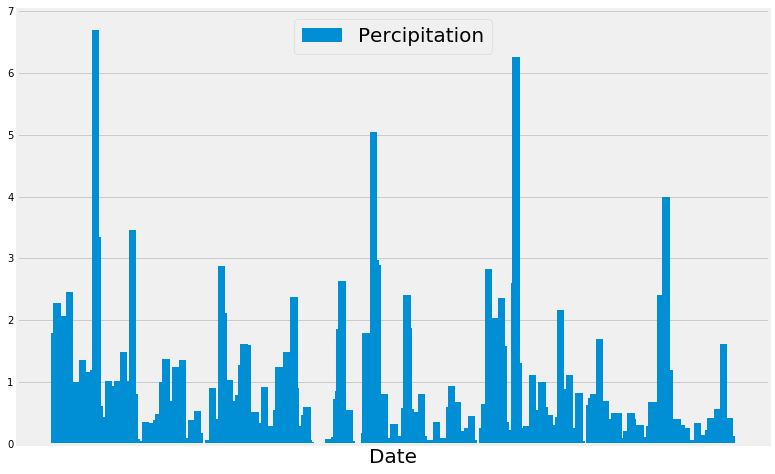

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    first()
tempT = latest_date[0]
myDate = dt.date(year=int(tempT[0:4]), month=int(tempT[5:7]), day=int(tempT[8:10]))
query_date = myDate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
          filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['Date', 'Percipitation'])
df.set_index('Date', inplace=True)

# Sort the dataframe by date
df.sort_values('Date', ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12,8))

plt.bar(df.index, df['Percipitation'], width=4)
plt.legend(labels = ['Percipitation'], loc='upper center', prop={'size': 20})


plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

plt.xlabel("Date", fontsize=20)
plt.grid(axis='x')
plt.show()


In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Percipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
myQuery = session.query(Station.station, func.count(Measurement.station)).\
            filter(Measurement.station == Station.station).\
            group_by(Station.station).\
            order_by(func.count(Station.station).desc()).all()
myQuery

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
minMaxAvg = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()
print(minMaxAvg)

[(54.0, 85.0, 71.66378066378067)]


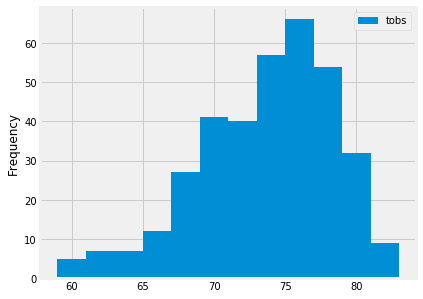

In [25]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_tmp = session.query(Station.station).\
            filter(Measurement.station == Station.station).\
            group_by(Station.station).\
            order_by(func.count(Station.station).desc()).limit(1).all()
station_tmp[0]

# Query to get latest date of the station
latest_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
    filter(Measurement.station == 'USC00519281').\
    first()
tempT = latest_date[0]

# Converts date received from tempT into int and feed it into datetime function
myDate = dt.date(year=int(tempT[0:4]), month=int(tempT[5:7]), day=int(tempT[8:10]))
query_date = myDate - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.tobs).\
          filter(Measurement.station == 'USC00519281').\
          filter(Measurement.date >= query_date).all()


df = pd.DataFrame(results, columns=['Temp'])
df.sort_values('Temp', ascending=False, inplace = True)
df.head()

plt.figure(figsize=(6,5))
plt.hist(df["Temp"], bins=12)
plt.legend(labels = ['tobs'])
plt.ylabel("Frequency")

plt.show()